Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random 
from pprint import pprint

Load and Prepare Data

In [2]:
df = pd.read_csv("census-income.data.csv") #Loading Census data

#Handling Missing Values

#df.info()

#Missing values in census-income.data.csv

#So we move on...

df1 = pd.read_csv("census-income.test.csv")

In [3]:
def determine_type_of_feature(df):
    feature_types = []
    n_unique_values_threshold = 15

    for column in df.columns:
        unique_values = df[column].unique()
        example_value = unique_values[0]

        if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_threshold):
            feature_types.append("Discrete")
        else:
            feature_types.append("Continuous")
    
    return feature_types

In [4]:
global FEATURE_TYPES
FEATURE_TYPES = determine_type_of_feature(df)




In [5]:
#Checking which all columns have missing values
def missing_values(df):
    c=0
    for i in df.columns:
        x,count_missing = np.unique(df[i].eq('?'),return_counts=True)
        if len(x)==2:
            print(i,"-",FEATURE_TYPES[c],"-",count_missing[1])
        # elif len(x)==1 and x[0] == False:
        #     print(i,"-",FEATURE_TYPES[c],"- 0",)
        c+=1

In [6]:
missing_values(df)

workclass - Discrete - 1836
occupation - Discrete - 1843
native_countr - Discrete - 583


In [7]:
missing_values(df1)

workclass - Discrete - 963
occupation - Discrete - 966
native_countr - Discrete - 274


In [8]:
#Since all columns are having the discrete value. We replace it with the missing values with the modes, i.e. the highest appearing value
mode_workclass = df.workclass.mode()[0]
mode_occupation = df.occupation.mode()[0]
mode_native_countr = df.native_countr.mode()[0]

#Filling the train and test data with the modes of missing values as they are discrete
df.workclass = df.workclass.replace('?', mode_workclass)
df.occupation = df.occupation.replace('?', mode_occupation)
df.native_countr = df.native_countr.replace('?', mode_native_countr)
missing_values(df)#No missing values




In [9]:
#Similarly for the other test data
#Since all columns are having the discrete value. We replace it with the missing values with the modes, i.e. the highest appearing value
mode_workclass = df1.workclass.mode()[0]
mode_occupation = df1.occupation.mode()[0]
mode_native_countr = df1.native_countr.mode()[0]

#Filling the train and test data with the modes of missing values as they are discrete
df1.workclass = df1.workclass.replace('?', mode_workclass)
df1.occupation = df1.occupation.replace('?', mode_occupation)
df1.native_countr = df1.native_countr.replace('?', mode_native_countr)

missing_values(df1)

#No missing values


Random Splitting Of Data

In [10]:
def train_test_split(df,test_size):
    #checks whether the test_size is a proportion of the total number of samples
    if isinstance(test_size,float): 
        test_size = round(test_size*len(df))

    #store random samples in the test and training data
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k = test_size)

    #random data points from sample sent to test and training data
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df , test_df

Data Pure?


In [11]:
def check_purity(data):
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) ==  1:
        return True    
    else:
        return False 

Classify Data

In [12]:
def classify_data(data): 
    label_column = data[:,-1]
    unique_classes , counts_unique_classes = np.unique(label_column,return_counts = True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification 

In [13]:
def get_potential_splits(data):
    potential_splits = {}
    rows , n_columns = data.shape

    for column_index in range(n_columns-1):
        values = data[:,column_index]
        unique_values = np.unique(values)
        
        
        potential_splits[column_index] = unique_values
            
    return potential_splits

In [14]:
# potential_splits = get_potential_splits(train_df.values)

# sns.lmplot(data = train_df, x = "petal_width", y = "petal_length",hue = "label", fit_reg = False,height=6,aspect = 1.5)

# # plt.vlines(x = potential_splits[3], ymin = 1, ymax =7)
# # plt.hlines(y=potential_splits[2],xmin=0,xmax =2.5)

Split Data

In [15]:
def split_data(data, split_column,split_value):
    split_column_values = data[:,split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    
    if type_of_feature == "Continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values > split_value]
    
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below , data_above

In [16]:
# split_value = 0.8
# plotting_df = pd.DataFrame(data,columns = df.columns)
# sns.lmplot(data = plotting_df, x = "petal_width", y = "petal_length", fit_reg=False)
# plt.vlines(x = split_value,ymin = 1, ymax =7)

In [17]:
def calculate_entropy(data):
    label_column = data[:,-1]
    rows , counts = np.unique(label_column , return_counts =True)

    probabilities = counts / counts.sum()
    entropy = np.sum(probabilities*-np.log2(probabilities))

    return entropy

In [18]:
def calculate_overall_entropy(data_below, data_above):
    
    n_data_points = len(data_below) + len(data_above)

    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (p_data_below*calculate_entropy(data_below) + p_data_above*calculate_entropy(data_above))

    return overall_entropy

In [19]:
def determine_best_splits(data, potential_splits):

    overall_entropy = 999
    
    for column_index in potential_splits:
        # print(COLUMN_HEADERS[column_index],"-",len(np.unique(data[:, column_index])))
        for value in potential_splits[column_index]:
            
            data_below, data_above = split_data(data,split_column = column_index,split_value = value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

Determine Whether Column is Discrete or Continuous


In [20]:
def decision_tree_algorithm(df , counter =0, min_samples=5, max_depth = 5):
    # print(counter)
    #Data Preparation
    if counter == 0:
        global COLUMN_HEADERS 
        global FEATURE_TYPES 
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df

    #Base Case 
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification 
    
    #Recursive case
    else:
        counter = counter + 1
        
        #helper functions
        potential_splits = get_potential_splits(data)        
        split_column,split_value = determine_best_splits(data,potential_splits)
        data_below,data_above = split_data(data,split_column,split_value)

        #checking for empty data

        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        #instantiating the sub-trees
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "Continuous":
            question = "{} <= {}".format(feature_name,split_value)

        else:
            question = "{} = {}".format(feature_name,split_value)

        sub_tree = {question:[]}

        #find answers (here recursion is used)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples , max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples , max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree




In [21]:
def classify_example(example,tree):
    question = list(tree.keys())[0]
    feature_name , comparison_operator, value = question.split()

    #Asking the question to the example
    if comparison_operator == "<=":

        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    #base Case
    if not isinstance(answer,dict):
        return answer

    #recursive part
    else:
        remaining_tree = answer
        return classify_example(example,remaining_tree)

In [22]:
def calculate_accuracy(df,tree):

    df["Classification"] = df.apply(classify_example,axis=1,args = (tree,))
    df["Classification_Correct"] = df.Classification == df.label

    accuracy = df.Classification_Correct.mean()

    return accuracy

In [23]:
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(classify_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions

In [24]:
def filter_df(df,question):
    feature,comparison_operator,value = question.split()

    if (comparison_operator) == "<=":
        df_yes = df[df[feature]<= float(value)]
        df_no = df[df[feature] > float(value)]
    
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no = df[df[feature].astype(str) != value]
        

    return df_yes,df_no

In [25]:
def pruning_result(tree, df_train, df_val):
    leaf = df_train.label.value_counts().index[0]
    errors_leaf = sum(df_val.label != leaf) #here we can find the accuracy also :D
    errors_decision_node = sum(df_val.label != make_predictions(df_val,tree))

    if errors_leaf <= errors_decision_node:
            return leaf
    else:
            return tree

In [26]:
def post_pruning(tree , df_train , df_val):
    question = list(tree.keys())[0]
    yes_answer , no_answer = tree[question]

    #base case
    if not isinstance(yes_answer,dict) and not isinstance(no_answer,dict):
        return pruning_result(tree , df_train , df_val)
    
    else: #Recursive case
        df_train_yes, df_train_no = filter_df(df_train , question)
        df_val_yes, df_val_no = filter_df(df_val , question)

        if isinstance(yes_answer,dict):
            yes_answer = post_pruning(yes_answer,df_train_yes,df_val_yes)

        if isinstance(no_answer,dict):
            no_answer = post_pruning(no_answer,df_train_no,df_val_no)
    
    tree = {question : [yes_answer,no_answer]}

    return pruning_result(tree , df_train , df_val)

In [27]:
def count_nodes(tree):
    if isinstance(tree, dict):
        count = 1  # Start with 1 for the current node
        for value in tree.values():
            count += count_nodes(value)  # Recursively count nodes in child dictionaries
        return count
    elif isinstance(tree, list):
        count = 0
        for node in tree:
            count += count_nodes(node)  # Recursively count nodes in child dictionaries
        return count
    else:
        return 1  # Reached a leaf node

In [28]:
def count_depth(tree):
    if isinstance(tree, dict):
        if not tree:  # Base case: empty dictionary
            return 1
        else:
            return 1 + max(count_depth(value) for value in tree.values())
    elif isinstance(tree, list):
        if not tree:  # Base case: empty list
            return 1
        else:
            return 1 + max(count_depth(item) for item in tree)
    else:
        return 0  # Base case: leaf node or invalid input

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_countr   32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [30]:
random.seed(0)
train_df = df
valid_df,test_df = train_test_split(df1,test_size=0.5)

In [31]:
tree = decision_tree_algorithm(train_df,max_depth = 100000)

In [32]:
pprint(tree,width=50)

{'marital_status = Married-civ-spouse': [{'education_num <= 12': [{'capital_gain <= 5013': [{'education_num <= 8': [{'age <= 36': [{'hours_per_week <= 48': [{'occupation = Tech-support': [{'fnlwgt <= 195516': ['<=50K',
                                                                                                                                                                                                                  '>50K']},
                                                                                                                                                                                            {'native_countr = Trinadad&Tobago': ['>50K',
                                                                                                                                                                                                                                 {'capital_loss <= 1651': [{'fnlwgt <= 180284': [{'fnlwgt <= 179666': [{'education = 11th': ['<=50K',
  

In [33]:
depth_count = count_depth(tree)
node_count = count_nodes(tree)
print(node_count)
print(depth_count)

6841
106


In [34]:
valid_df.iloc[1]

age                          34
workclass               Private
fnlwgt                   198693
education                  10th
education_num                 6
marital_status    Never-married
occupation        Other-service
relationship      Not-in-family
race                      White
sex                        Male
capital_gain                  0
capital_loss                  0
hours_per_week               30
native_countr     United-States
label                    <=50K.
Name: 5, dtype: object

In [35]:
valid_df['label'] = valid_df['label'].str.replace('.', '')
test_df['label'] = test_df['label'].str.replace('.', '')

In [36]:
example = valid_df.iloc[1]
example

age                          34
workclass               Private
fnlwgt                   198693
education                  10th
education_num                 6
marital_status    Never-married
occupation        Other-service
relationship      Not-in-family
race                      White
sex                        Male
capital_gain                  0
capital_loss                  0
hours_per_week               30
native_countr     United-States
label                     <=50K
Name: 5, dtype: object

In [37]:
accuracy_train = calculate_accuracy(train_df,tree)
accuracy_val = calculate_accuracy(valid_df,tree)
accuracy_test = calculate_accuracy(test_df,tree)
print("Training Set Accuracy:",accuracy_train)
print("Validation Set Accuracy:",accuracy_val)
print("Test Set Accuracy:",accuracy_test)

Training Set Accuracy: 0.9765670587512668
Validation Set Accuracy: 0.8287679646235107
Test Set Accuracy: 0.8156019656019656


In [38]:
pruned_tree = post_pruning(tree,train_df,valid_df)

In [40]:
print(count_nodes(pruned_tree))
print(count_depth(pruned_tree))


1453
84


In [41]:
pruned_tree

{'marital_status = Married-civ-spouse': [{'education_num <= 12': [{'capital_gain <= 5013': [{'education_num <= 8': [{'age <= 36': ['<=50K',
          {'age <= 66': [{'capital_loss <= 1672': [{'education_num <= 5': [{'hours_per_week <= 49': ['<=50K',
                  {'hours_per_week <= 80': [{'occupation = Other-service': ['<=50K',
                      {'fnlwgt <= 177995': ['<=50K',
                        {'education_num <= 3': ['<=50K',
                          {'age <= 44': ['<=50K',
                            {'capital_gain <= 0': [{'fnlwgt <= 259532': [{'occupation = Handlers-cleaners': ['>50K',
                                  {'age <= 51': ['>50K', '<=50K']}]},
                                '>50K']},
                              '<=50K']}]}]}]}]},
                    '<=50K']}]},
                {'fnlwgt <= 364913': ['<=50K',
                  {'fnlwgt <= 431513': [{'fnlwgt <= 411652': ['<=50K',
                      '>50K']},
                    '<=50K']}]}]},
         

In [43]:
accuracy_train = calculate_accuracy(train_df,pruned_tree)
accuracy_val = calculate_accuracy(valid_df,pruned_tree)
accuracy_test = calculate_accuracy(test_df,pruned_tree)
print("Training Set Accuracy:",accuracy_train)
print("Validation Set Accuracy:",accuracy_val)
print("Test Set Accuracy:",accuracy_test)

Training Set Accuracy: 0.896532661773287
Validation Set Accuracy: 0.8846579044343447
Test Set Accuracy: 0.8528255528255528


In [44]:
# metrics = {"max_depth":[],"acc_tree":[],"acc_tree_pruned":[]}

# for n in range(2,110,2):
#     tree = decision_tree_algorithm(train_df,max_depth=n)
#     tree_pruned = post_pruning(tree,train_df,valid_df)

#     metrics["max_depth"].append(n)
#     metrics["acc_tree"].append(calculate_accuracy(test_df,tree))
#     metrics["acc_tree_pruned"].append(calculate_accuracy(test_df,tree_pruned))

# df_metrics = pd.DataFrame(metrics)
# df_metrics = df_metrics.set_index("max_depth")

In [45]:
copy_tree = tree
copy_prune = pruned_tree

In [46]:
metrics = {"max_depth":[],"acc_tree_test":[],"acc_tree_pruned_test":[],"acc_tree_train":[],"acc_tree_pruned_train":[],"acc_tree_validation":[],"acc_tree_pruned_validation":[]}

In [47]:
p1 = pruning_result(copy_tree,train_df,valid_df)

In [48]:
p2 = pruning_result(p1,train_df,valid_df)

In [49]:
count_nodes(p2)

6841

In [50]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8140 entries, 13835 to 1759
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     8140 non-null   int64 
 1   workclass               8140 non-null   object
 2   fnlwgt                  8140 non-null   int64 
 3   education               8140 non-null   object
 4   education_num           8140 non-null   int64 
 5   marital_status          8140 non-null   object
 6   occupation              8140 non-null   object
 7   relationship            8140 non-null   object
 8   race                    8140 non-null   object
 9   sex                     8140 non-null   object
 10  capital_gain            8140 non-null   int64 
 11  capital_loss            8140 non-null   int64 
 12  hours_per_week          8140 non-null   int64 
 13  native_countr           8140 non-null   object
 14  label                   8140 non-null   object
 15  Class

In [51]:
len(train_df.columns)

17

In [53]:
unpruned_tree1 = copy_tree
metrics1 = metrics

In [54]:
metrics = metrics1
unpruned_tree = unpruned_tree1

In [56]:
copy_tree = None

for n in range(8,40,10):
    
    if len(train_df.columns) > 15:
        train_df = train_df.drop(["Classification","Classification_Correct"],axis=1)
        valid_df = valid_df.drop(["Classification","Classification_Correct"],axis=1)
        test_df = test_df.drop(["Classification","Classification_Correct"],axis=1)
    
    print("Training tree with depth",n,"...")
    copy_tree = decision_tree_algorithm(train_df,max_depth=n)
    print("Nodes -",count_nodes(copy_tree),"and depth-",count_depth(copy_tree))
    
    unpruned_tree.append(copy_tree)

    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(test_df,tree))
    




Training tree with depth 8 ...
Nodes - 173 and depth- 16


AttributeError: 'dict' object has no attribute 'append'

dict_keys(['max_depth', 'acc_tree', 'acc_tree_pruned'])

In [ ]:
metrics.update({'valid_acc':[],"valid_acc_pruned":[],"train_acc":[],"train_acc_pruned":[]})

In [ ]:
metrics

{'max_depth': [8, 18, 28, 38, 48, 58, 68, 78, 88, 98, 108],
 'acc_tree': [0.8542997542997544,
  0.8421375921375921,
  0.8216216216216217,
  0.8164619164619165,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656],
 'acc_tree_pruned': [0.8544226044226044,
  0.8587223587223587,
  0.8533169533169533,
  0.8529484029484029,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528],
 'valid_acc': [],
 'valid_acc_pruned': [],
 'train_acc': [],
 'train_acc_pruned': []}

In [ ]:
for i in unpruned_tree:
    print(i)

{'marital_status = Married-civ-spouse': [{'education_num <= 12': [{'capital_gain <= 5013': [{'education_num <= 8': [{'age <= 36': [{'hours_per_week <= 48': [{'occupation = Tech-support': [{'fnlwgt <= 195516': ['<=50K', '>50K']}, {'native_countr = Trinadad&Tobago': ['>50K', '<=50K']}]}, {'relationship = Not-in-family': ['>50K', '<=50K']}]}, {'age <= 66': [{'capital_loss <= 1672': ['<=50K', {'capital_loss <= 1977': ['>50K', '<=50K']}]}, {'fnlwgt <= 74141': [{'sex = Male': ['<=50K', '>50K']}, '<=50K']}]}]}, {'age <= 35': [{'age <= 24': [{'hours_per_week <= 45': [{'fnlwgt <= 515797': ['<=50K', '>50K']}, {'occupation = Transport-moving': ['>50K', '<=50K']}]}, {'capital_loss <= 1740': ['<=50K', {'capital_loss <= 1977': ['>50K', '<=50K']}]}]}, {'capital_loss <= 1740': ['<=50K', {'capital_loss <= 1977': [{'age <= 66': ['>50K', '<=50K']}, {'capital_loss <= 2149': ['<=50K', '>50K']}]}]}]}]}, {'age <= 60': [{'education_num <= 1': ['<=50K', '>50K']}, {'capital_gain <= 6514': ['>50K', {'capital_gai

In [ ]:
metrics = metrics

In [ ]:
pruned1 = pruned

In [ ]:
metrics["acc_tree"] = []

In [ ]:
prune =[]
copy_prune = None
for i in unpruned_tree:

    if len(train_df.columns) > 15:
        train_df = train_df.drop(["Classification","Classification_Correct"],axis=1)
        valid_df = valid_df.drop(["Classification","Classification_Correct"],axis=1)
        test_df = test_df.drop(["Classification","Classification_Correct"],axis=1)

    print("Pruning tree with depth",n,"...")
    copy_prune = post_pruning(i,train_df,valid_df)
    print("Nodes -",count_nodes(copy_prune),"and depth-",count_depth(copy_prune))

    prune.append(copy_prune)

    metrics["acc_tree_pruned"].append(calculate_accuracy(test_df,copy_prune))
    metrics["acc_tree"].append(calculate_accuracy(test_df,i))

Pruning tree with depth 108 ...
Nodes - 85 and depth- 16
Pruning tree with depth 108 ...
Nodes - 535 and depth- 36
Pruning tree with depth 108 ...
Nodes - 1051 and depth- 56
Pruning tree with depth 108 ...
Nodes - 1363 and depth- 72
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84
Pruning tree with depth 108 ...
Nodes - 1453 and depth- 84


In [ ]:
print(metrics["acc_tree"])
print(metrics["acc_tree_pruned"])

[0.8542997542997544, 0.8421375921375921, 0.8216216216216217, 0.8164619164619165, 0.8156019656019656, 0.8156019656019656, 0.8156019656019656, 0.8156019656019656, 0.8156019656019656, 0.8156019656019656, 0.8156019656019656]
[0.8544226044226044, 0.8587223587223587, 0.8533169533169533, 0.8529484029484029, 0.8528255528255528, 0.8528255528255528, 0.8528255528255528, 0.8528255528255528, 0.8528255528255528, 0.8528255528255528, 0.8528255528255528]


In [ ]:
print(len(prune))
print(len(unpruned_tree))

11
11


In [ ]:
metrics

{'max_depth': [8, 18, 28, 38, 48, 58, 68, 78, 88, 98, 108],
 'acc_tree': [0.8542997542997544,
  0.8421375921375921,
  0.8216216216216217,
  0.8164619164619165,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656],
 'acc_tree_pruned': [0.8544226044226044,
  0.8587223587223587,
  0.8533169533169533,
  0.8529484029484029,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528],
 'valid_acc': [],
 'valid_acc_pruned': [],
 'train_acc': [],
 'train_acc_pruned': []}

In [ ]:
c =0 
for i in unpruned_tree:
    
    print(c)
    metrics["train_acc"].append(calculate_accuracy(train_df,i))
    metrics["valid_acc"].append(calculate_accuracy(valid_df,i))


for i in prune:

    print(c)
    metrics["train_acc_pruned"].append(calculate_accuracy(train_df,i))
    metrics["valid_acc_pruned"].append(calculate_accuracy(valid_df,i))



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
metrics

{'max_depth': [8, 18, 28, 38, 48, 58, 68, 78, 88, 98, 108],
 'acc_tree': [0.8542997542997544,
  0.8421375921375921,
  0.8216216216216217,
  0.8164619164619165,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656,
  0.8156019656019656],
 'acc_tree_pruned': [0.8544226044226044,
  0.8587223587223587,
  0.8533169533169533,
  0.8529484029484029,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528,
  0.8528255528255528],
 'valid_acc': [0.8594767227613316,
  0.8507554354501904,
  0.8306104901117799,
  0.8297506448839209,
  0.8290136346886132,
  0.8287679646235107,
  0.8287679646235107,
  0.8287679646235107,
  0.8287679646235107,
  0.8287679646235107,
  0.8287679646235107],
 'valid_acc_pruned': [0.8614420832821521,
  0.8749539368627932,
  0.8808500184252549,
  0.8842893993366908,
  0.8846579044343447,
  0.8846579044343447,
  0.88465790443

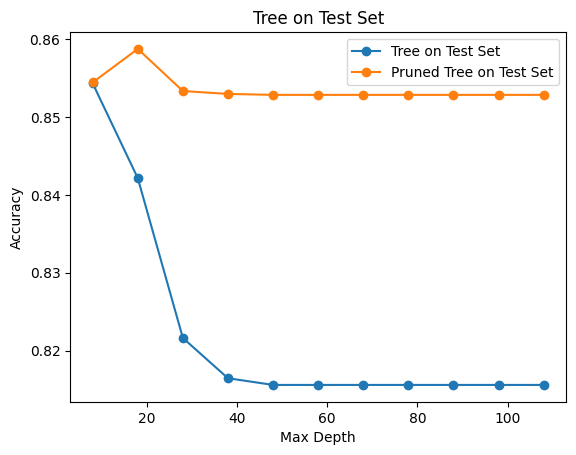

In [ ]:
plt.plot(metrics["max_depth"],metrics["acc_tree"],label="Tree on Test Set",marker = "o")

plt.plot(metrics["max_depth"],metrics["acc_tree_pruned"],label="Pruned Tree on Test Set",marker="o")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

plt.title("Tree on Test Set")
plt.legend()

plt.show()

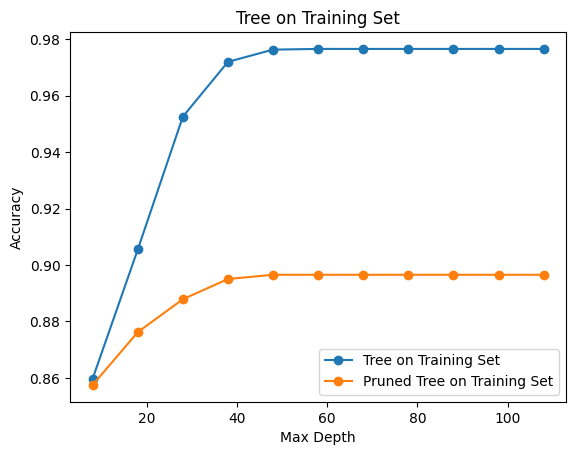

In [ ]:
plt.plot(metrics["max_depth"],metrics["train_acc"],label="Tree on Training Set",marker = "o")

plt.plot(metrics["max_depth"],metrics["train_acc_pruned"],label="Pruned Tree on Training Set",marker="o")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

plt.title("Tree on Training Set")
plt.legend()

plt.show()

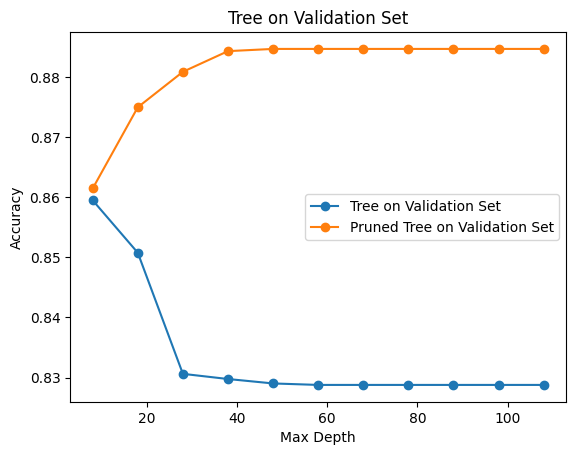

In [ ]:
plt.plot(metrics["max_depth"],metrics["valid_acc"],label="Tree on Validation Set",marker = "o")

plt.plot(metrics["max_depth"],metrics["valid_acc_pruned"],label="Pruned Tree on Validation Set",marker="o")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

plt.title("Tree on Validation Set")
plt.legend()

plt.show()